In [1]:
# Here evaluate 0-shot reference mapping on an internal (Allen Institute) human brain dataset. 
# otebook has been cleaned up, needs to be re-run (~1 hour run time).

In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
from scipy.stats import mode
import scanpy as sc
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, 
                            recall_score, f1_score, confusion_matrix)
import warnings
import subprocess
import sys
from tqdm import tqdm
from rich import print as rprint  

from schelp.utils.config import load_config

import matplotlib.pyplot as plt
import seaborn as sns

import torchtext
torchtext.disable_torchtext_deprecation_warning() # to supress deprecation warnings

import scgpt as scg
import faiss


custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", font_scale=0.8, rc=custom_params)
%config InlineBackend.figure_format='retina'

/allen/programs/celltypes/workgroups/mousecelltypes/Rohan/code/scgpt/scGPT/scgpt/model/model.py:21: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
/allen/programs/celltypes/workgroups/mousecelltypes/Rohan/code/scgpt/scGPT/scgpt/model/multiomic_model.py:19: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
/allen/programs/celltypes/workgroups/mousecelltypes/Rohan/env/miniconda3/envs/scgpt/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
paths = load_config(dataset_key="init")
subprocess.run(["tree", "-L", "1", paths["data"]])
subprocess.run(["tree", "-L", "1", paths["pretrained_models"]])

/allen/programs/celltypes/workgroups/mousecelltypes/Rohan/code/scgpt/datasets
├── COVID-19-splitted
├── Human-Brain
└── Lung-Kim-splitted

4 directories, 0 files
/allen/programs/celltypes/workgroups/mousecelltypes/Rohan/code/scgpt/pretrained_models
├── scGPT_CP
├── scGPT_brain
└── scGPT_human

4 directories, 0 files


CompletedProcess(args=['tree', '-L', '1', PosixPath('/allen/programs/celltypes/workgroups/mousecelltypes/Rohan/code/scgpt/pretrained_models')], returncode=0)

We set the columns storing gene name columns, batch key and cell type key.

In [4]:
data_dir = str(paths["data"])
adata = sc.read_h5ad(str(paths["data"]) + '/Human-Brain/train_rna_geneformer.h5ad', backed="r")


In [5]:
cell_type_key = "supertype_train_label"
gene_col = "gene_ids"

display(adata.var[gene_col].to_frame().head(3))
display(adata.obs[cell_type_key].to_frame().head(3))

,gene_ids
PRDM16-DT,PRDM16-DT
LRRC38,LRRC38
KAZN,KAZN


,supertype_train_label
ATTTACCCAAACAGGC-L8TX_210506_01_E08-1153814230,L4 IT_2
TTCAGGATCGATTGAC-L8TX_210430_01_G04-1153814211,L2_3 IT_6
ATCACTTAGCGCCTAC-LKTX_191204_01_A01-1156636525,L2_3 IT_1


In [6]:
n_cells = adata.shape[0]
train_ind, test_ind = train_test_split(np.arange(n_cells), test_size=0.2, random_state=42)

train_ind = np.sort(train_ind)
test_ind = np.sort(test_ind)

adata_train = adata[train_ind].to_memory()
adata_test = adata[test_ind].to_memory()

Embed the reference dataset

In [7]:
model_dir =  Path(str(paths["pretrained_models"] / "scGPT_brain"))
ref_embed_adata = scg.tasks.embed_data(
    adata_train,
    model_dir,
    gene_col=gene_col,
    batch_size=128,
)

scGPT - INFO - match 851/859 genes in vocabulary of size 60697.


/allen/programs/celltypes/workgroups/mousecelltypes/Rohan/code/scgpt/scGPT/scgpt/model/model.py:77: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(
Embedding cells: 100%|█████████▉| 6135/6136 [03:38<00:00, 43.45it/s] Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/allen/programs/celltypes/workgroups/mousecelltypes/Rohan/env/miniconda3/envs/scgpt/lib/python3.9/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File

Embed the query dataset

In [8]:
test_embed_adata = scg.tasks.embed_data(
    adata_test,
    model_dir,
    gene_col=gene_col,
    batch_size=128,
)

scGPT - INFO - match 851/859 genes in vocabulary of size 60697.


/allen/programs/celltypes/workgroups/mousecelltypes/Rohan/code/scgpt/scGPT/scgpt/model/model.py:77: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(
Embedding cells: 100%|█████████▉| 1533/1534 [01:10<00:00, 43.88it/s]Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/allen/programs/celltypes/workgroups/mousecelltypes/Rohan/env/miniconda3/envs/scgpt/lib/python3.9/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/allen/programs/celltypes/workgroups/mousecelltypes/Rohan/env/miniconda3/envs/scgpt/lib/python3.9/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/allen/programs/celltypes/workgroups/mousecelltypes/Rohan/env/miniconda3/envs/scgpt/lib/python3.9/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  F

Mark the reference vs. query cells and mask the cell types on query cells

In [9]:
# concatenate the two datasets
adata_concat = test_embed_adata.concatenate(ref_embed_adata, batch_key="dataset")
# mark the reference vs. query dataset
adata_concat.obs["is_ref"] = ["Query"] * len(test_embed_adata) + ["Reference"] * len(
    ref_embed_adata
)
adata_concat.obs["is_ref"] = adata_concat.obs["is_ref"].astype("category")
# mask the query dataset cell types
adata_concat.obs[cell_type_key] = adata_concat.obs[cell_type_key].astype("category")
adata_concat.obs[cell_type_key] = adata_concat.obs[cell_type_key].cat.add_categories(["To be predicted"])
adata_concat.obs[cell_type_key][: len(test_embed_adata)] = "To be predicted"

/allen/programs/celltypes/workgroups/mousecelltypes/Rohan/.tmpdir/ipykernel_280951/4201321170.py:2: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_concat = test_embed_adata.concatenate(ref_embed_adata, batch_key="dataset")
/allen/programs/celltypes/workgroups/mousecelltypes/Rohan/.tmpdir/ipykernel_280951/4201321170.py:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df

## Visualize the embeddings

In [10]:
# sc.pp.neighbors(adata_concat, use_rep="X_scGPT")
# sc.tl.umap(adata_concat)
# sc.pl.umap(
#     adata_concat, color=["is_ref", cell_type_key], wspace=0.4, frameon=False, ncols=1
# )

## Reference mapping and transfer the annotations

We run the reference mapping using cell-level majority voting. You may adjust the `k` parameter to control the number of nearest neighbors to consider for voting.

In [11]:
ref_cell_embeddings = ref_embed_adata.obsm["X_scGPT"]
test_emebd = test_embed_adata.obsm["X_scGPT"]

k = 10  # number of neighbors

# Build index
index = faiss.IndexFlatL2(ref_cell_embeddings.shape[1])
index.add(ref_cell_embeddings)

# Query dataset, k - number of closest elements (returns 2 numpy arrays)
distances, labels = index.search(test_emebd, k)

idx_list=[i for i in range(test_emebd.shape[0])]
preds = []
sim_list = distances

In [12]:
# building the index on top of the embeddings takes long - 27 minutes for ~1 800,000 cells. + 200,000 queries. 
# annoy / scann are other fast knn classifier options for majority-vote based class label prediction.

In [13]:
for k in tqdm(idx_list):
    idx = labels[k]
    pred = ref_embed_adata.obs[cell_type_key].iloc[idx].value_counts()
    preds.append(pred.index[0])
gt = adata_test.obs[cell_type_key].to_numpy()

100%|██████████| 196324/196324 [01:12<00:00, 2707.54it/s]


## Evaluate the performance

In [14]:
res_dict = {
    "accuracy":  np.round(accuracy_score(gt, preds),3),
    "precision": np.round(precision_score(gt, preds, average="macro"),3),
    "recall":    np.round(recall_score(gt, preds, average="macro"),3),
    "macro_f1":  np.round(f1_score(gt, preds, average="macro"),3),
}

rprint(res_dict)

/allen/programs/celltypes/workgroups/mousecelltypes/Rohan/env/miniconda3/envs/scgpt/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'accuracy': 0.756, 'precision': 0.689, 'recall': 0.572, 'macro_f1': 0.594}

Confusion matrix:

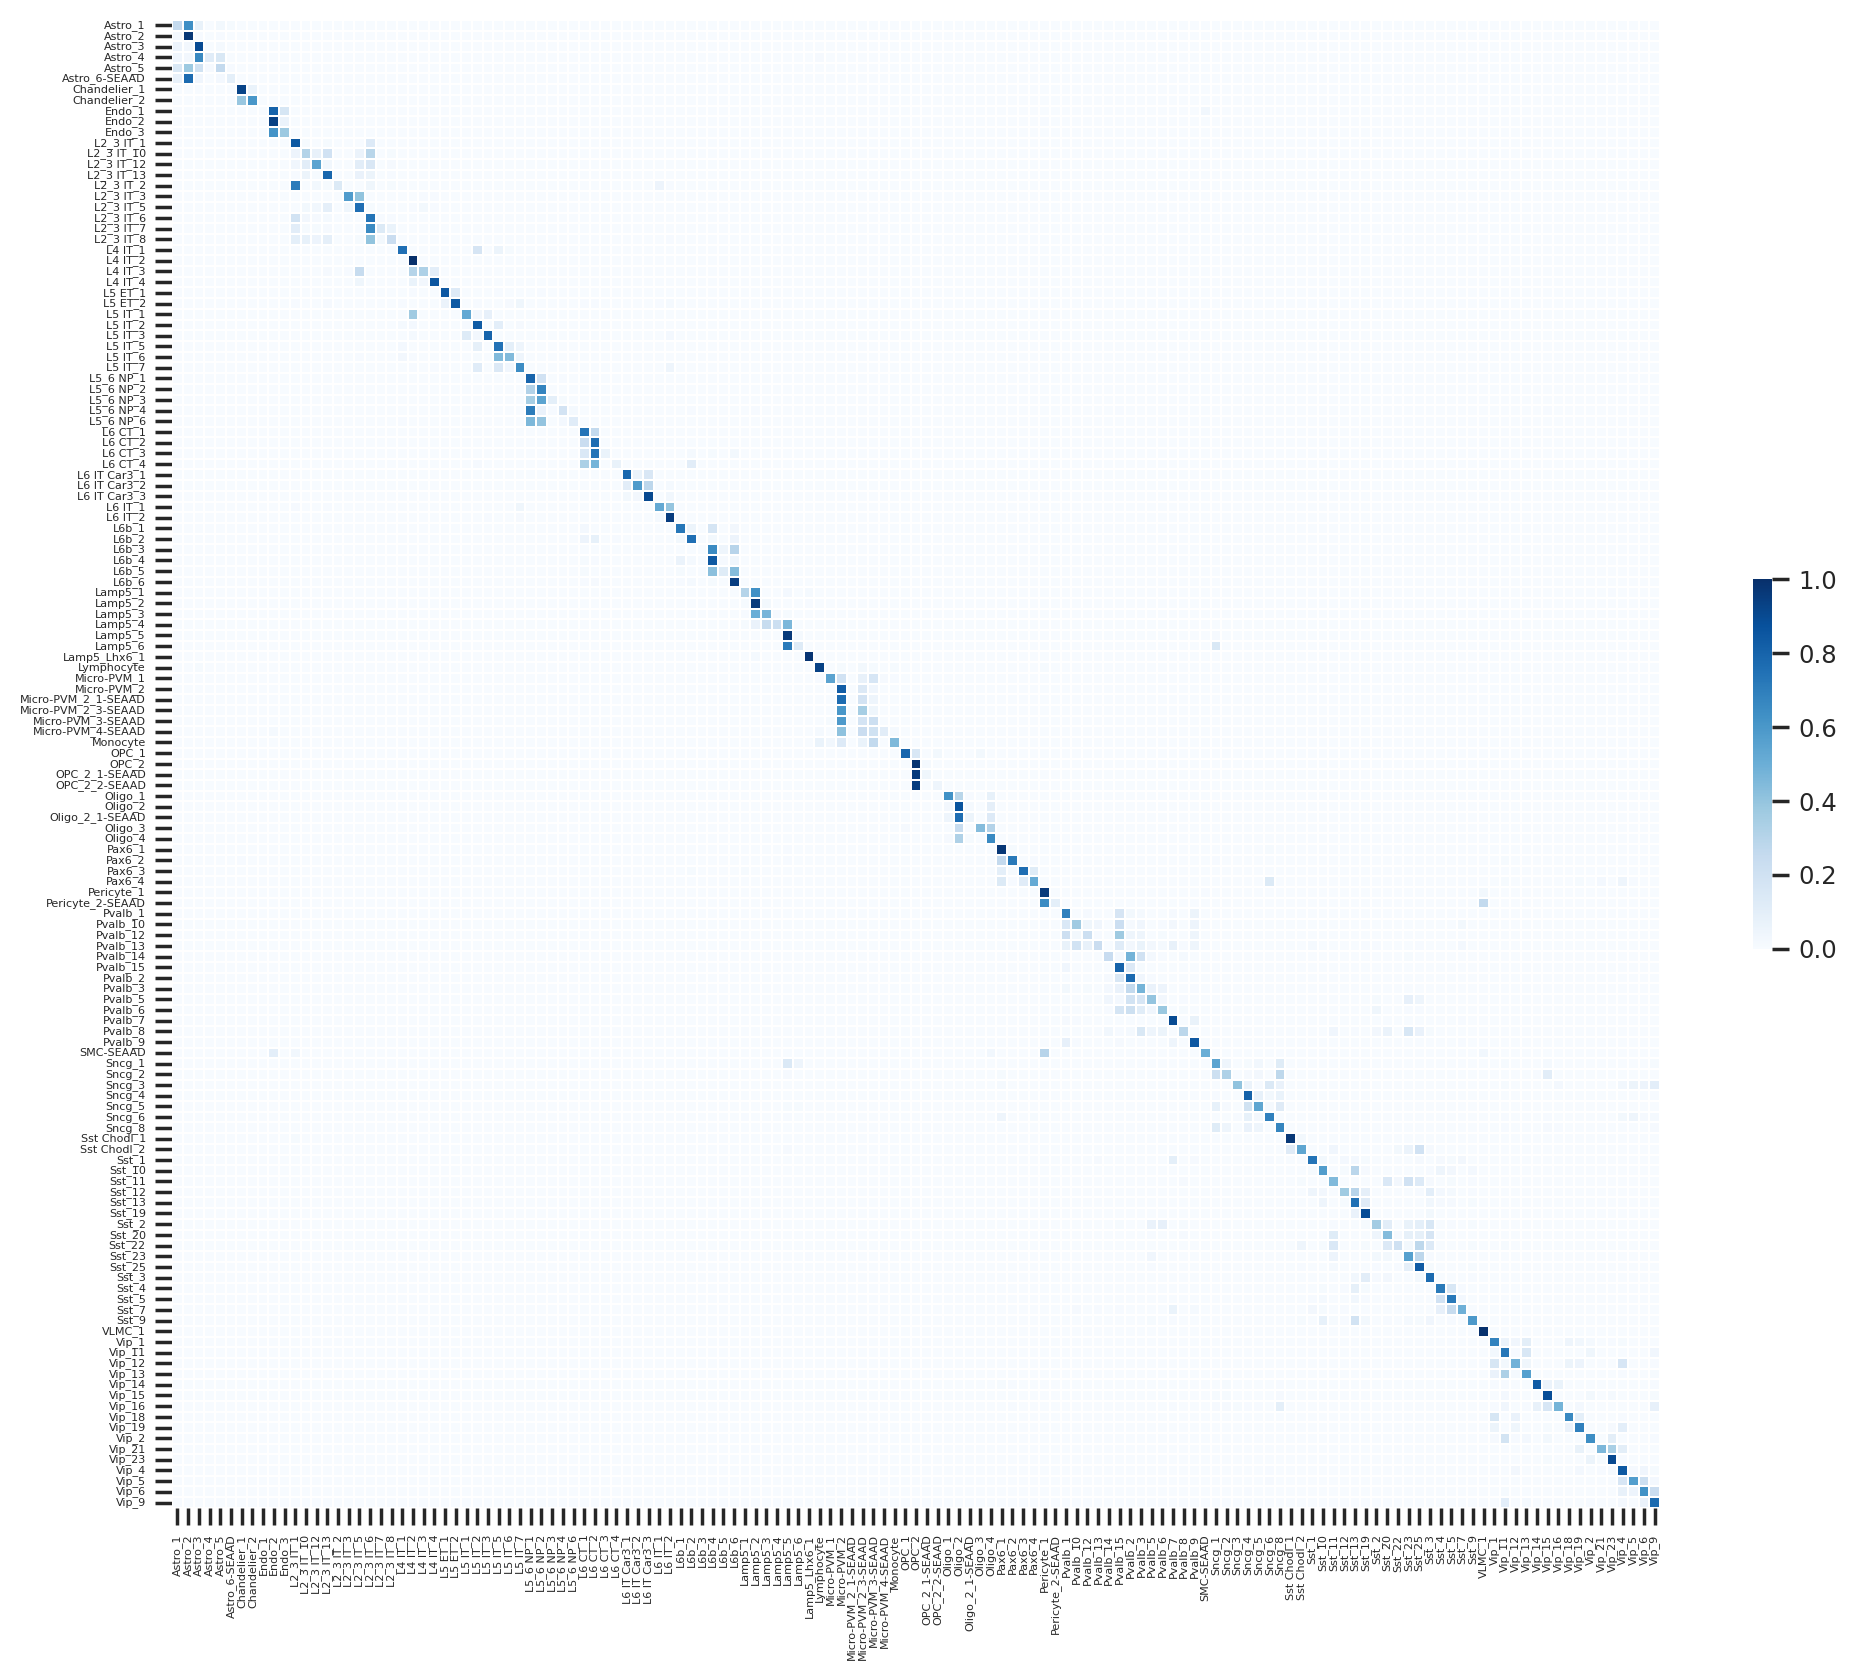

In [15]:
y_true = gt
y_pred = preds
cell_type_list = np.unique(y_true)
matrix = confusion_matrix(y_true, y_pred, labels=cell_type_list)
matrix = matrix.astype("float") / matrix.sum(axis=1)[:, np.newaxis]

df = pd.DataFrame(matrix, index=cell_type_list[:matrix.shape[0]], columns=cell_type_list[:matrix.shape[1]])

f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(df,  
            cmap='Blues',
            annot=False ,fmt=".2f", 
            annot_kws={'size': 5}, 
            vmin=0, 
            vmax=1,
            ax=ax,
            linewidths=0.1,
            square=True,
            cbar_kws={'shrink': .2},
            xticklabels=1, yticklabels=1)
# reduce font for xticklabels
plt.xticks(fontsize=4)
plt.yticks(fontsize=4)
plt.show()
